In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs
#
from copy import deepcopy as cp

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [4]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'

Figures will be saved in: /home/561/erd561/figures/SAMexp/t06_multi_diagnostics



In [5]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:35042' processes=8 cores=8>
CPU times: user 1.49 s, sys: 312 ms, total: 1.8 s
Wall time: 10.5 s


In [6]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

nyf_years = np.arange(477, 487)
ctrl_years = np.arange(566, 576)
# hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(611, 621)

nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
# hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(1-nyf_years_len, 0), 
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len+1 + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

for y in nyf_years:
    path1.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
    path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20]
30
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/

In [7]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        SST = \
            xr.open_dataset(p1, decode_times=False).\
            temp.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            drop(('geolon_t', 'geolat_t')).\
            mean(dim='time')
        
        tau_x = \
            xr.open_dataset(p2, decode_times=False).\
            tau_x.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))
        
        sea_level = \
            xr.open_dataset(p2, decode_times=False).\
            sea_level.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            mean(dim='time').\
            drop(('geolon_t', 'geolat_t'))*100
        
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                drop(('geolon_t', 'geolat_t')).\
                mean(dim='time')
            ], 'year'
            )
        
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))
            ], 'year'
            )
        
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p2, decode_times=False).\
                sea_level.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').\
                drop(('geolon_t', 'geolat_t'))*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
        
    else:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')
            ], 'year'
            )
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p2, decode_times=False).\
                sea_level.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')*100
            ], 'year'
            )
        print(str(p1) + ' OK')
print(SST)

xt_ocean = SST.xt_ocean
xt_ocean_corrected = xt_ocean + 360
SST = SST.assign_coords(xt_ocean=xt_ocean_corrected)
xu_ocean = tau_x.xu_ocean
xu_ocean_corrected = xu_ocean + 360
tau_x = tau_x.assign_coords(xu_ocean=xu_ocean_corrected)
sea_level = sea_level.assign_coords(xt_ocean=xt_ocean_corrected)

SST = SST.assign_coords(year=years)
tau_x = tau_x.assign_coords(year=years)
sea_level = sea_level.assign_coords(year=years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output570/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output571/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output572/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output573/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output574/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output575/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output611/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output612/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output613/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output614/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output615/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output616/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output617/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output618/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output619/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output620/ocean_month.nc OK
<xarray.DataArray 'temp' (year: 30, yt_ocean: 220, xt_ocean: 280)>
array([[[-0.401731, -0.380208, ...,  2.608085,  2.577984],
        [-0.406891, -0.376817, ...,  2.718419,  2.699332],
        ...,
        [23.918919, 23.935635, ..., 25.873558, 25.851952],
        [24.118069, 24.150646, ..., 26.02486 , 25.955761]],

       [[-0.469344, -0.446292, ...,  2.588118,  2.527822],
        [-0.461044, -0.434482, ...,  2.785284,  2.702575],
        ...,
        [23.966635, 23.966448, ..., 25.850706, 25.82425 ],
        [24.18553 , 24.199455, ..., 25.92586 , 25.899218]],

       ...,

       [[-0.440748, -0.452596, ...,  3.481239,  3.464719],
        [-0.406318, -0.394741, ...,  3.53492 ,  3.514677],
        ...,
        [24.305384, 24.327362, ..., 26.453362, 26.462786],
        [24.34794 , 24.386576, ..., 26.552256, 26.523329]],

       [[-0.584847, -0.561112, ...,  3.521433,  3.537624],
        [-0.536606, -0.498623

In [8]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        u = \
            xr.open_dataset(p2, decode_times=False).\
            u.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))*100
        
        v = \
            xr.open_dataset(p2, decode_times=False).\
            v.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))*100
        
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        u = \
            xr.concat([
                u,
                xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))*100
            ], 'year'
            )
        
        v = \
            xr.concat([
                v,
                xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
        
    else:
        u = \
            xr.concat([
                u,
                xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')*100
            ], 'year'
            )
        
        v = \
            xr.concat([
                v,
                xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
print(u)
print(v)

u = u.assign_coords(xu_ocean=xu_ocean_corrected)
v = v.assign_coords(xu_ocean=xu_ocean_corrected)

u = u.assign_coords(year=years)
v = v.assign_coords(year=years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output570/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output571/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output572/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output573/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output574/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output575/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output611/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output612/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output613/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output614/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output615/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output616/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output617/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output618/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output619/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output620/ocean_month.nc OK
<xarray.DataArray 'u' (year: 30, yu_ocean: 220, xu_ocean: 281)>
array([[[ 3.226749,  4.579499, ..., 18.250782, 18.151443],
        [ 5.424019,  6.164174, ..., 19.0497  , 18.447664],
        ...,
        [-0.875426,  0.742908, ...,  0.589452,  0.455355],
        [-0.446703,  1.042892, ..., -1.665959, -1.539691]],

       [[ 3.464878,  4.758625, ..., 22.660906, 21.203909],
        [ 6.008337,  6.769628, ..., 25.706745, 25.299252],
        ...,
        [ 3.099197,  4.51613 , ..., -0.40462 ,  0.101112],
        [ 1.777051,  3.967316, ..., -3.365498, -2.952523]],

       ...,

       [[ 1.236042,  2.801782, ...,  1.987195,  1.858018],
        [ 4.828698,  6.666809, ...,  4.16678 ,  3.738938],
        ...,
        [-3.853745, -3.035244, ..., -3.405099, -3.256104],
        [-4.637712, -4.178194, ..., -5.1062  , -5.772229]],

       [[ 1.955348,  3.127618, ...,  5.933039,  7.634661],
        [ 3.964375,  5.737937, .

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [13]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1[10:], path2[10:]):
    if p1 == path1[10]:
        net_sfc_heating = \
            xr.open_dataset(p2, decode_times=False).\
            net_sfc_heating.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            mean(dim='time')
        
        tau_curl = \
            xr.open_dataset(p2, decode_times=False).\
            tau_curl.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            mean(dim='time')
        
        ekman_we = \
            xr.open_dataset(p2, decode_times=False).\
            ekman_we.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            mean(dim='time')
        
        print(str(p1) + ' OK')
        
    else:
        net_sfc_heating = \
            xr.concat([
                net_sfc_heating,
                xr.open_dataset(p2, decode_times=False).\
                net_sfc_heating.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        
        tau_curl = \
            xr.concat([
                tau_curl,
                xr.open_dataset(p2, decode_times=False).\
                tau_curl.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        
        ekman_we = \
            xr.concat([
                ekman_we,
                xr.open_dataset(p2, decode_times=False).\
                ekman_we.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        
        print(str(p1) + ' OK')
print(net_sfc_heating)
print(ekman_heat)
print(ekman_we)

net_sfc_heating = net_sfc_heating.assign_coords(xt_ocean=xt_ocean_corrected)
tau_curl = tau_curl.assign_coords(xt_ocean=xt_ocean_corrected)
ekman_we = ekman_we.assign_coords(xt_ocean=xt_ocean_corrected)

net_sfc_heating = net_sfc_heating.assign_coords(year=years[10:])
tau_curl = tau_curl.assign_coords(year=years[10:])
ekman_we = ekman_we.assign_coords(year=years[10:])

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output570/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output571/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output572/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output573/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output574/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output575/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output611/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output612/ocean_month.nc OK
/g/data/e14/

In [14]:
net_sfc_heating = net_sfc_heating.assign_coords(xt_ocean=xt_ocean_corrected)
tau_curl = tau_curl.assign_coords(xt_ocean=xt_ocean_corrected)
ekman_we = ekman_we.assign_coords(xt_ocean=xt_ocean_corrected)

net_sfc_heating = net_sfc_heating.assign_coords(year=years[10:])
tau_curl = tau_curl.assign_coords(year=years[10:])
ekman_we = ekman_we.assign_coords(year=years[10:])

In [15]:
SST_nyf = SST.sel(year=slice(-9,0)).mean(dim='year')
SST_hist5069 = SST.sel(year=slice(1,10)).mean(dim='year')
SST_rcp85 = SST.sel(year=slice(11,20)).mean(dim='year')

tau_x_nyf = tau_x.sel(year=slice(-9,0)).mean(dim='year')
tau_x_hist5069 = tau_x.sel(year=slice(1,10)).mean(dim='year')
tau_x_rcp85 = tau_x.sel(year=slice(11,20)).mean(dim='year')

sea_level_nyf = sea_level.sel(year=slice(-9,0)).mean(dim='year')
sea_level_hist5069 = sea_level.sel(year=slice(1,10)).mean(dim='year')
sea_level_rcp85 = sea_level.sel(year=slice(11,20)).mean(dim='year')

u_nyf = u.sel(year=slice(-9,0)).mean(dim='year')
u_hist5069 = u.sel(year=slice(1,10)).mean(dim='year')
u_rcp85 = u.sel(year=slice(11,20)).mean(dim='year')

v_nyf = v.sel(year=slice(-9,0)).mean(dim='year')
v_hist5069 = v.sel(year=slice(1,10)).mean(dim='year')
v_rcp85 = v.sel(year=slice(11,20)).mean(dim='year')

net_sfc_heating_hist5069 = net_sfc_heating.sel(year=slice(1,10)).mean(dim='year')
net_sfc_heating_rcp85 = net_sfc_heating.sel(year=slice(11,20)).mean(dim='year')

tau_curl_hist5069 = tau_curl.sel(year=slice(1,10)).mean(dim='year')
tau_curl_rcp85 = tau_curl.sel(year=slice(11,20)).mean(dim='year')

ekman_we_hist5069 = ekman_we.sel(year=slice(1,10)).mean(dim='year')
ekman_we_rcp85 = ekman_we.sel(year=slice(11,20)).mean(dim='year')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  s)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  s)


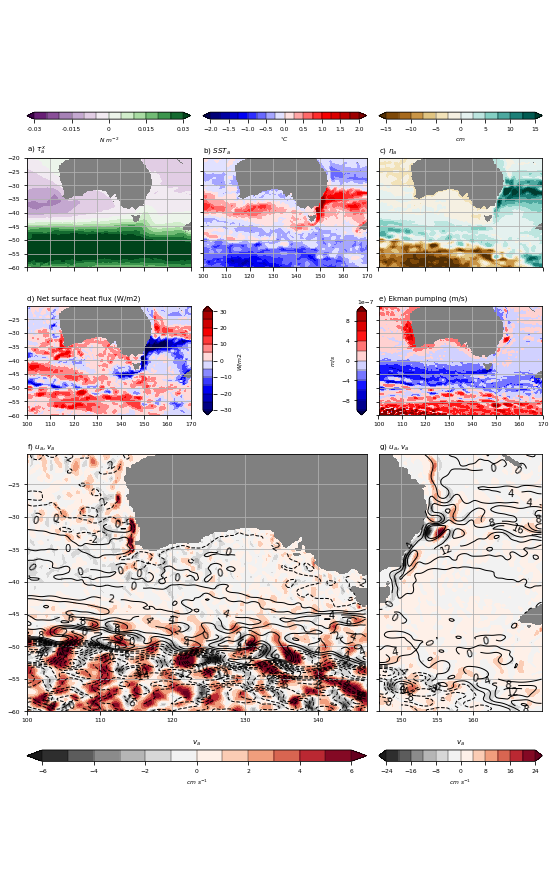

In [66]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

fig = plt.figure() 
fig.set_size_inches(7.5,12)
matplotlib.rcParams.update({'font.size': 6}) 
col = 3
row = 6

ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
cont_lev = arange(-0.03,0.03,0.005)
anom = tau_x_rcp85 - tau_x_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PRGn, extend='both')
plt.grid()
plt.title(r'a) $\tau^{x}_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
cbar.set_ticks([-0.03, -0.015, 0, 0.015, 0.03])
cbar.set_ticklabels(['-0.03', '-0.015', '0', '0.015', '0.03'])
cbar.set_label(r'$N\ m^{-2}$') 
ax.axis('off')



ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1)
cont_lev = arange(-2,2,0.25)
anom = SST_rcp85 - SST_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.title('')
plt.grid()
plt.title('b) $SST_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')
ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$^{\circ}C$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1)
cont_lev = arange(-15,15,2.5)
anom = sea_level_rcp85 - sea_level_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.BrBG, extend='both')
plt.title('')
plt.grid()
plt.title(r'c) $\eta_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')
ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$cm$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 0), rowspan=1, colspan=1)
cont_lev = arange(-30,30,5)
anom = net_sfc_heating_rcp85 - net_sfc_heating_hist5069
contf1 = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.title('')
plt.grid()
plt.title(r'd) Net surface heat flux (W/m2)', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
# ax = plt.subplot2grid((row, col), (2, 1), rowspan=1, colspan=1)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("left", size="7%", pad="2%")
# cbar = plt.colorbar(contf1, cax=cax, orientation='vertical', drawedges=True)
# # cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
# cbar.set_label(r'$W/m2$') 
# ax.axis('off')


# ax = plt.subplot2grid((row, col), (2, 1), rowspan=1, colspan=1)
# cont_lev = arange(-0.00000001, 0.00000001, 0.000000001)
# anom = tau_curl_rcp85 - tau_curl_hist5069
# contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
# plt.title('')
# plt.grid()
# plt.title(r'e) Meridional velocity (cm/s)', loc='left')
# plt.xlabel('')
# plt.ylabel('')
# ax.set_facecolor('gray')
# plt.gca().set_yticklabels('')
# ax = plt.subplot2grid((row, col), (3, 1), rowspan=1, colspan=1)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("top", size="7%", pad="2%")
# cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# # cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
# cbar.set_label(r'$cm/s$') 
# ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 2), rowspan=1, colspan=1)
cont_lev = arange(-0.000001,0.000001,0.0000002)
anom = ekman_we_rcp85 - ekman_we_hist5069
contf2 = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.title('')
plt.grid()
plt.title(r'e) Ekman pumping (m/s)', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')
ax = plt.subplot2grid((row, col), (2, 1), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cbar = plt.colorbar(contf2, cax=cax, orientation='vertical', drawedges=True)
cbar.ax.yaxis.tick_left()
cbar.ax.yaxis.set_label_position('left')
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$m/s$')
cax = ax_divider.append_axes("left", size="7%", pad="2%")
cbar = plt.colorbar(contf1, cax=cax, orientation='vertical', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$W/m2$') 
ax.axis('off')



ax = plt.subplot2grid((row, col), (3, 0), rowspan=2, colspan=2)
cont_lev = arange(-6, 6, 1)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [100, 147]
Y_LIM = [-60, -20]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
speed = np.sqrt(U**2 + V**2)
contf = plt.contourf(X, Y, V, add_colorbar=False, 
                     levels=cont_lev, cmap=plt.cm.RdGy_r, extend='both')

anom = sea_level_rcp85 - sea_level_hist5069
X = anom.xt_ocean[
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])]
Y = anom.yt_ocean[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
ANOM = np.array(anom[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1]),
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])
])

levels1 = arange(0,16,2)
CS = plt.contour(X, Y, ANOM, colors='k', levels=levels1, linewidths=1)
plt.clabel(CS, inline=3, fontsize=10, fmt='%1.0f')

levels2 = arange(-16,-2,2)
CS = plt.contour(X, Y, ANOM, colors='k', levels=levels2, linewidths=1, linestyles='--')
plt.clabel(CS, inline=3, fontsize=10, fmt='%1.0f')


plt.title('')
plt.grid()
plt.title('f) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (5, 0), rowspan=1, colspan=2)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="12%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$cm\ s^{-1}$') 
cbar.ax.set_title('$v_{a}$')
# cax2 = ax_divider.append_axes("top", size="12%", pad="80%")
# cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
# cbar.set_ticks(Q_lev)
# cbar.set_label(r'$cm\ s^{-1}$')
# cbar.ax.set_title('$Speed_{a}$ (only for $|u_{a}| > ' + str(tol) + '\ cm\ s^{-1}$)')
ax.axis('off')


ax = plt.subplot2grid((row, col), (3, 2), rowspan=2, colspan=1)
cont_lev = arange(-24, 24, 4)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [147, 170]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
speed = np.sqrt(U**2 + V**2)
contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdGy_r, extend='both')

anom = sea_level_rcp85 - sea_level_hist5069
X = anom.xt_ocean[
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])]
Y = anom.yt_ocean[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
ANOM = np.array(anom[
    find_nearest_index(anom.yt_ocean.data, Y_LIM[0]):find_nearest_index(anom.yt_ocean.data, Y_LIM[1]),
    find_nearest_index(anom.xt_ocean.data, X_LIM[0]):find_nearest_index(anom.xt_ocean.data, X_LIM[1])
])

levels1 = arange(0,16,4)
CS = plt.contour(X, Y, ANOM, colors='k', levels=levels1, linewidths=1)
plt.clabel(CS, inline=3, fontsize=10, fmt='%1.0f')

levels2 = arange(-16,-4,4)
CS = plt.contour(X, Y, ANOM, colors='k', levels=levels2, linewidths=1, linestyles='--')
plt.clabel(CS, inline=3, fontsize=10, fmt='%1.0f')

plt.title('')
plt.grid()
plt.title('g) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.xticks(arange(150,160,5))
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (5, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="12%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$cm\ s^{-1}$') 
cbar.ax.set_title('$v_{a}$')
# cax2 = ax_divider.append_axes("top", size="12%", pad="80%")
# cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
# cbar.set_ticks(Q_lev)
# cbar.set_label(r'$cm\ s^{-1}$')
# cbar.ax.set_title('$Speed_{a}$ (only for $|u_{a}| > ' + str(tol) + '\ cm\ s^{-1}$)')
ax.axis('off')




fig.tight_layout(pad=0, w_pad=-1.5, h_pad=0)

output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig2_.png', bbox_inches='tight', dpi=300)